# ENGR-E 221 Intelligent Systems I Fall 2020

## Lab 13 Motivation Towards Reinforement Learning with a Virtual Pet Example

Thursday Lab: 12/03/2020 3:15 pm - 4:30 pm

Friday Lab: 12/04/2020 9:25 am - 10:40 am

### Outline


1. Review Slides from Lecure 

2. Discuss our pets Q-table

3. Create a virtual pet 



### Introduction  (15 minutes)

The objective of lab 13 is to familiarize you with the the use of Q-tables and their use in Reinforcement Learning by going through a virtual pet example. This code will also be used for the hoemwork. 


In [3]:
import matplotlib.pylab as plt
import numpy as np

class pet:
    def __init__( self ):
# action 
        self.EXERCISE = 0;
        self.EAT = 1; 
# state 
        self.energy = 1; 
        self.fitness = 1;
        self.health = 1; 
# parameters 
        self.r_use = 0.5; 
        self.r_FD = 0.1; 
        self.r_heal = 0.01; 
        self.r_HD = 0.01; 

def update_pet( pet , dt ):
    # update energy 
    pet.energy += dt*( 5*pet.EAT - pet.r_use*(1+4*pet.EXERCISE)*pet.energy ); 
    # update fitness
    pet.fitness += dt*( pet.EXERCISE*np.heaviside(pet.energy-1.0,0) - pet.r_FD*pet.fitness ) ;
    # update health 
    ff = pet.fitness;
    ee = pet.energy;
    hh = pet.health; 
    pet.health += dt*( pet.r_heal*(0.1+0.9*np.heaviside(ff-1.0,0.0)*np.min([ff-1.0,2.0]))    );  
    pet.health -= dt*( pet.r_HD*(1.0+1000.0*np.heaviside(0.5-ee,0.0)+2.0*np.heaviside(ee-2.0,0.0))*hh ); 
    # return 
    return pet; 


def run_model( setup ):
    T = np.linspace( 0 , setup['max_time'] , setup['numsteps'] ); 
    dt = T[2]-T[1]; 
    E = T.copy();
    F = T.copy();
    H = T.copy(); 
    pete = pet(); 
    pete.energy = setup['energy']; 
    pete.fitness = setup['fitness']; 
    pete.health = setup['health']; 
    pete.EAT = setup['EAT'];
    pete.EXERCISE = setup['EXERCISE']; 

    for n in range(0,len(T)):
        pete = update_pet( pete , dt ); 
        E[n] = pete.energy;
        H[n] = pete.health; 
        F[n] = pete.fitness;
    return pete , T,E,F,H

def reward( pet, T,E,F,H ):
    dt = T[2]-T[1]; 
    rw = dt*np.sum( H ); 
    return rw; 

def plot_model( pet , T,E,F,H ):
    plt.plot( T,E,'g', T,F, 'b', T,H, 'r' ); 
    plt.legend( ['energy','fitness','health'] );
    plt.xlabel( 'time' ); 
    s  = 'final health: ' + str( pete.health ) + '     reward: ' + str(reward(pet,T,E,F,H));
    plt.title( s ) ; 
    return; 

def make_setup():
    SETUP = {}; 
    SETUP['health']= 1; 
    SETUP['fitness'] =1;
    SETUP['energy'] = 1; 
    SETUP['EAT'] = 1; 
    SETUP['EXERCISE'] = 0;
    SETUP['max_time'] = 250.0;
    SETUP['numsteps'] = 1000; 
    
    ## create Q(S,A) table 
    # states
    states = [ [False,False] , [False,True], [True,False], [True,True] ]  
    # actions 
    actions = [ [0,0], [2,0], [0,2], [2,2] ]
    # Q(S,A) table 
    Q = np.zeros( (len(states),len(actions)) ); 
    
    params = {};
    params['learning_rate'] = 0.1;
    params['discount_rate'] = 0.1;
    params['exploration_rate'] = 0.2; 
    params['max_iterations'] = 100000;
    params['dt'] = 0.0025;  
    
    return SETUP, states, actions, params, Q;

# evaluate state
def evaluate_state( Fit_last, Fit, Health_last, Health ):
    out = [False,False];
    if( Fit >= Fit_last ):
        out[0] = True; 
    if( Health >= Health_last ):
        out[1] = True;
    state_index = 2*np.int( out[0] ) + np.int( out[1] ); 
    return out, state_index;

# evaluate reward
def evaluate_reward( pet ):
    return pet.health; 

## function to choose next action
def choose_action( my_state_index, actions,Q, exploration_rate ):
    n = Q[my_state_index,:].argmax( );
    if( np.random.uniform() < exploration_rate ):
        # choose random
        n = np.random.randint(len(actions)); 
    return actions[n], n; 
    

def reinforcement_learning( states,actions,Q, params):
    Fit_last = 0; Health_last = 0; 
    pete = pet();  
    for n in range( params['max_iterations'] ):
       # if( np.mod(n,500) == 0 ):
       #     print( 'n=' + str(n) )
        # get current state 
        state,si = evaluate_state(Fit_last, pete.fitness,Health_last, pete.health);
        # choose action
        action,ai = choose_action(si,actions,Q,params['exploration_rate']); 

        # set last values 
        Fit_last = pete.fitness; 
        Health_last = pete.health; 

        # update with the action 
        pete.EAT = action[0]; 
        pete.EXERCISE = action[1]; 
        pete = update_pet( pete , params['dt'] ); 
        # evaluate reward 
        reward = evaluate_reward( pete ); 
        TD = reward - Q[si,ai]; 

        # future reward 
        next_state,next_si= evaluate_state(Fit_last,pete.fitness,Health_last,pete.health);
        future_reward = np.max( Q[next_si,:] ); 

        # update Q
        Q[si,ai] = Q[si,ai] + \
        params['learning_rate']*(TD + params['discount_rate']*future_reward); 

    return Q; 

def run_model_dynamic( setup, states,actions,Q, params ):
    T = np.linspace( 0 , setup['max_time'] , setup['numsteps'] ); 
    dt = T[2]-T[1]; 
    E = T.copy();	F = T.copy();	H = T.copy(); 
    eat_history = T.copy();	exercise_history = T.copy();

    pete = pet(); 
    pete.energy = setup['energy']; 
    pete.fitness = setup['fitness']; 
    pete.health = setup['health']; 
    pete.EAT = setup['EAT'];
    pete.EXERCISE = setup['EXERCISE']; 
    Fit_last = -1;
    Health_last = -1; 

    for n in range(0,len(T)):
        # get current state 
        state,si = evaluate_state(Fit_last, pete.fitness,Health_last, pete.health);
        # choose action
        action,ai = choose_action(si,actions,Q,params['exploration_rate']); 
        pete.EAT = action[0];
        pete.EXERCISE = action[1]; 
        eat_history[n] = pete.EAT;
        exercise_history[n] = pete.EXERCISE; 

        Fit_last = pete.fitness;   # set last values 
        Health_last = pete.health; # set last values 

        pete = update_pet( pete , dt ); 
        E[n] = pete.energy;
        H[n] = pete.health; 
        F[n] = pete.fitness;
    return pete , T,E,F,H, eat_history, exercise_history; 


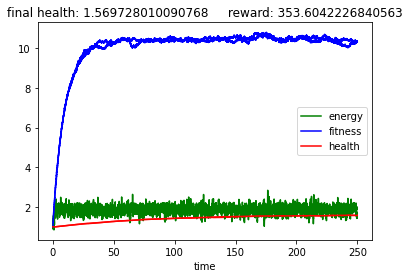

In [4]:
setup, states, actions, params, Q = make_setup(); 

Q = reinforcement_learning( states,actions,Q, params)

setup['numsteps'] *= 10; 

pete,T,E,F,H, eat_hist,ex_hist = run_model_dynamic( setup, states,actions,Q,params)
plot_model( pete, T,E,F,H ); 

params['exploration_rate'] = 0.001; 
params['discount_rate'] = 0.005;
params['exploration_rate'] = 0.2; 
pete,T,E,F,H, eat_hist,ex_hist = run_model_dynamic( setup, states,actions,Q,params)
plot_model( pete, T,E,F,H ); 